In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from datetime import datetime
sns.set(style="whitegrid")
%matplotlib inline

In [2]:
NOTEBOOK_DIR = os.getcwd()
BASE_DIR = os.path.dirname(NOTEBOOK_DIR)
DATA_DIR = os.path.join(BASE_DIR, "data")
DATA_DIR_PATH = os.path.join(DATA_DIR, "Data_cars.csv")
DATA_ZIP_DIR_PATH = os.path.join(DATA_DIR, "Data_cars.csv.zip")

In [3]:
if not os.path.exists(DATA_DIR_PATH):
    !unzip "${DATA_ZIP_DIR_PATH}"

In [4]:
data_car = pd.read_csv(DATA_DIR_PATH)

In [5]:
data_car.head()

,Price,Make,Model,Model_year,Mileage,Fuel,Gearbox,Online,Description
0,11220.0,PEUGEOT,308,2014,94341.0 km,Diesel,mécanique,06/07/2018 à 3h47,"modele: 308 (2E GENERATION), version: 1.6 HDI ..."
1,57526.0,BMW,X6,2015,39051.0 km,Diesel,automatique,03/04/2018 à 16h41,"modele: X6 F16, version: (F16) XDRIVE30D 258 M..."
2,80379.0,AUDI,RS6,2014,75381.0 km,Essence,automatique,30/07/2018 à 1h55,"modele: RS6 (3E GENERATION) AVANT, version: II..."
3,2830.0,FORD,KA,2007,92282.0 km,Essence,mécanique,09/07/2018 à 14h12,"modele: KA, version: 1.3 70 FUN, puissance_fis..."
4,12925.0,FIAT,TIPO,2018,10.0 km,Essence,mécanique,19/05/2018 à 3h52,"modele: TIPO 2 SW, version: II SW 1.4 95 POP, ..."


## Remarque:

- faut saisir: 5018 dans le model année
- la puissance fiscal: 0 => problème
- il y a des vieux voitures ou des anciennes modèles voitures qui ont le `Mileage` = 1 km ou un peu roulé

In [6]:
data_car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166695 entries, 0 to 166694
Data columns (total 9 columns):
Price          166695 non-null float64
Make           166695 non-null object
Model          166695 non-null object
Model_year     166695 non-null int64
Mileage        166695 non-null object
Fuel           166695 non-null object
Gearbox        166695 non-null object
Online         166695 non-null object
Description    166695 non-null object
dtypes: float64(1), int64(1), object(7)
memory usage: 11.4+ MB


In [7]:
def online_clean(df):
    datetime_format = "%d/%m/%Y à %Hh%M"
    df.Online = [datetime.strptime(d, datetime_format) for d in df.Online.values]
    return df

def mileage_clean(df):
    df.Mileage = [float(m.split(' ')[0]) for m in df.Mileage.values]
    return df

def descriptions_clean(df):
    regex_pattern = r"modele:\s*(?P<modele>.*?(?=,)),\sversion:\s*(?P<version>.*?(?=,)),\spuissance_fiscale:\s*(?P<puissance_fiscale>.*?(?=,)),\sportes:\s*(?P<portes>.*?(?=,)),\soptions:\s*(?P<Descriptions>.*?(?=,)),\scouleur:\s(?P<couleur>.*$)"
    version = []
    puissance_fiscale = []
    portes = []
    options = []
    couleur = []
    for i in range(df.shape[0]):
        match = re.search(regex_pattern, df.Description[i])
        version.append(match.group(2))
        puissance_fiscale.append(match.group(3))
        portes.append(match.group(4))
        options.append(match.group(5))
        couleur.append(match.group(6))
    df["version"] = list(map(str.lower, version))
    df["puissance_fiscale"] = puissance_fiscale
    df["portes"] = portes
    df["options"] = options
    df["couleur"] = list(map(str.lower, couleur))
    del df["Description"]
    return df

def car_age(df):
    df["age"] = [int(df.loc[i,"Online"].year) - int(df.loc[i, "Model_year"]) for i in range(df.shape[0])]
    return df

def preprocessing(data, preprocessors=None):
    df = data.copy(deep=True)
    if preprocessors is not None:
        for preprocessor in preprocessors:
            df = preprocessor(df)
        return df
    else:
        return df

In [8]:
data_car_preprocessed = preprocessing(data_car, [online_clean, mileage_clean, descriptions_clean, car_age])

In [9]:
data_car_preprocessed.head()

,Price,Make,Model,Model_year,Mileage,Fuel,Gearbox,Online,version,puissance_fiscale,portes,options,couleur,age
0,11220.0,PEUGEOT,308,2014,94341.0,Diesel,mécanique,2018-07-06 03:47:00,1.6 hdi fap 92ch business 5p,4,5.0,banquette arrière 3 places;volant cuir;cache b...,blanc banquise,4
1,57526.0,BMW,X6,2015,39051.0,Diesel,automatique,2018-04-03 16:41:00,(f16) xdrive30d 258 m sport bva8,16,5.0,triangle de presignalisation et trousse de pre...,carbonschwarz metallise,3
2,80379.0,AUDI,RS6,2014,75381.0,Essence,automatique,2018-07-30 01:55:00,iii avant 4.0 tfsi 560 quattro tiptronic,47,5.0,banquette arrière 3 places;écran tactile;témoi...,noir panthere cristal,4
3,2830.0,FORD,KA,2007,92282.0,Essence,mécanique,2018-07-09 14:12:00,1.3 70 fun,5,3.0,direction assistée;jantes alu;rétroviseurs éle...,jaune,11
4,12925.0,FIAT,TIPO,2018,10.0,Essence,mécanique,2018-05-19 03:52:00,ii sw 1.4 95 pop,5,5.0,Volant alu & cuir;Bluetooth inclut musique en ...,blanc verni,0


In [11]:
version_origin = list(data_car_preprocessed.version.value_counts().keys())
version_origin[:5], len(version_origin)

(['(2) 1.2 puretech 82 style 5p',
  'ii (2) 1.2 8v 69 lounge',
  'iii 1.2 puretech 82 feel',
  'iv 1.6 dci 130 energy intens',
  '1.6 dci 130 energy intens'],
 31494)

In [11]:
data_car_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166695 entries, 0 to 166694
Data columns (total 14 columns):
Price                166695 non-null float64
Make                 166695 non-null object
Model                166695 non-null object
Model_year           166695 non-null int64
Mileage              166695 non-null float64
Fuel                 166695 non-null object
Gearbox              166695 non-null object
Online               166695 non-null datetime64[ns]
version              166695 non-null object
puissance_fiscale    166695 non-null object
portes               166695 non-null object
options              166695 non-null object
couleur              166695 non-null object
age                  166695 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(2), object(9)
memory usage: 17.8+ MB


In [42]:
data_car_preprocessed[data_car_preprocessed.version == np.array(version_origin)[np.array(cylindre) == '71.000'][0]]

,Price,Make,Model,Model_year,Mileage,Fuel,Gearbox,Online,version,puissance_fiscale,portes,options,couleur,age
151633,9357.0,CITROEN,C4,2014,69510.0,Diesel,mécanique,2018-08-16 16:35:00,societe e-hdi 115 club entreprise 71.000,6,5.0,régulateur limiteur de vitesse;cache bagages;d...,gris,4


In [84]:
regex_cyclindre = "\d+[\.,]\d+"
regex_cv = "\s+\d{1,3}\s?"
cylindre = []
cheveaux = []
for i in range(data_car_preprocessed.version.shape[0]):
    if data_car_preprocessed.version[i] == 'ii allurehdifap2.0150cv':
        data_car_preprocessed.version[i] = 'ii allurehdifap 2.0 150cv'
    #print(i, data_car_preprocessed.version[i])
    text = data_car_preprocessed.version[i]
    # supprimer les nombres du kilogmetrage dans le text
    text = re.sub("\d+[\.,]\d+km", "", text)
    text = re.sub("(159.226|76.538|87.480|71.000)", "", text)
    cl = re.findall(regex_cyclindre, text)
    text = re.sub(regex_cyclindre, "", text)
    # supprimer les nombres du porte dans text
    text = re.sub("\d+p", "", text)
    cv = re.findall(regex_cv, text)
    if len(cl) == 0:
        #print("None")
        cylindre.append("NaN")
    else:
        #print("More 2")
        cylindre.append(cl[0].strip().replace(",", "."))
    
    if len(cv) == 0:
        cheveaux.append("NaN")
    else:
        cheveaux.append(cv[0].strip())
    #cylindre.append(re.findall(regex, data_car_preprocessed.version[i])[0])

In [85]:
len(cylindre), len(cheveaux)

(166695, 166695)

In [74]:
np.unique(cylindre)

array(['0.6', '0.8', '0.9', '1.0', '1.1', '1.2', '1.25', '1.3', '1.4',
       '1.5', '1.6', '1.7', '1.8', '1.9', '16.4', '19.3', '2.0', '2.1',
       '2.2', '2.3', '2.4', '2.5', '2.6', '2.7', '2.8', '2.9', '3.0',
       '3.1', '3.2', '3.3', '3.4', '3.5', '3.6', '3.7', '3.8', '3.9',
       '4.0', '4.1', '4.2', '4.3', '4.4', '4.5', '4.6', '4.7', '4.8',
       '5.0', '5.2', '5.3', '5.4', '5.5', '5.7', '5.9', '6.0', '6.2',
       '6.3', '6.4', '6.5', '6.6', '6.7', '6.75', '6.8', '6.9', 'NaN'],
      dtype='<U4')

In [86]:
data_car_preprocessed["cylindre"] = cylindre
data_car_preprocessed["cv"] = cheveaux

In [87]:
data_car_preprocessed.head()

,Price,Make,Model,Model_year,Mileage,Fuel,Gearbox,Online,version,puissance_fiscale,portes,options,couleur,age,cylindre,cv
0,11220.0,PEUGEOT,308,2014,94341.0,Diesel,mécanique,2018-07-06 03:47:00,1.6 hdi fap 92ch business 5p,4,5.0,banquette arrière 3 places;volant cuir;cache b...,blanc banquise,4,1.6,92
1,57526.0,BMW,X6,2015,39051.0,Diesel,automatique,2018-04-03 16:41:00,(f16) xdrive30d 258 m sport bva8,16,5.0,triangle de presignalisation et trousse de pre...,carbonschwarz metallise,3,NaN,258
2,80379.0,AUDI,RS6,2014,75381.0,Essence,automatique,2018-07-30 01:55:00,iii avant 4.0 tfsi 560 quattro tiptronic,47,5.0,banquette arrière 3 places;écran tactile;témoi...,noir panthere cristal,4,4.0,560
3,2830.0,FORD,KA,2007,92282.0,Essence,mécanique,2018-07-09 14:12:00,1.3 70 fun,5,3.0,direction assistée;jantes alu;rétroviseurs éle...,jaune,11,1.3,70
4,12925.0,FIAT,TIPO,2018,10.0,Essence,mécanique,2018-05-19 03:52:00,ii sw 1.4 95 pop,5,5.0,Volant alu & cuir;Bluetooth inclut musique en ...,blanc verni,0,1.4,95


In [92]:
def cylindre_cv_extra(df):
    regex_cyclindre = "\d+[\.,]\d+"
    regex_cv = "\s+\d{1,3}\s?"
    cylindre = []
    cheveaux = []
    for i in range(df.version.shape[0]):
        if df.version[i] == 'ii allurehdifap2.0150cv':
            df.version[i] = 'ii allurehdifap 2.0 150cv'
        #print(i, data_car_preprocessed.version[i])
        text = df.version[i]
        # supprimer les nombres du kilogmetrage dans le text
        text = re.sub("\d+[\.,]\d+km", "", text)
        text = re.sub("(159.226|76.538|87.480|71.000)", "", text)
        cl = re.findall(regex_cyclindre, text)
        text = re.sub(regex_cyclindre, "", text)
        # supprimer les nombres du porte dans text
        text = re.sub("\d+p", "", text)
        cv = re.findall(regex_cv, text)
        if len(cl) == 0:
            #print("None")
            cylindre.append("NaN")
        else:
            #print("More 2")
            cylindre.append(cl[0].strip().replace(",", "."))

        if len(cv) == 0:
            cheveaux.append("NaN")
        else:
            cheveaux.append(cv[0].strip())
        #cylindre.append(re.findall(regex, data_car_preprocessed.version[i])[0])
    df["cylindre"] = cylindre
    df["cv"] = cv
    return df

## Duplicated offers

- In the case that poster modifies used car's price after posted date to sold this car.
- All car's information will be same out of Online date and car price
- So we try to find all duplicated row followed car caracteristics and maintain just the price of the last online date

# find dupplicated
fix_col = list(data_car_preprocessed.columns)
fix_col.remove("Online")
fix_col.remove("Price")
duplicateRowsDF = data_car_preprocessed[data_car_preprocessed.sort_values(by="Online").duplicated(fix_col, keep='last')]
duplicateRowsDF.head()

# get all duplicated row and check if it sort by time and see how's price evoluate
allDuplicateRowsDF = data_car_preprocessed[data_car_preprocessed.sort_values(by="Online").duplicated(fix_col, keep=False)]
allDuplicateRowsDF = list(allDuplicateRowsDF.index)
table = pd.pivot_table(data_car_preprocessed.iloc[allDuplicateRowsDF,:].reset_index().sort_values(by="Online"), values=["Online", "Price", "index"], index=fix_col, aggfunc=list)
table

# verify some data
data_car_preprocessed.iloc[[7272, 35351, 79192, 131758, 138531],:].sort_values(by=["Online", "Price"])

- there are 9490 duplicated row
- next step, we need to exclude these rows from our original data

duplicateRowsDF.shape

len(duplicateRowsDF.index)

# all index duplicated without the last row (sort by date time)
row_duplicated = list(duplicateRowsDF.index)
row_rested = list(set(data_car_preprocessed.index) - set(row_duplicated))

# as we mentionne above, we'll get the last deal price on marketplace
data_car_preprocessed_non_duplicate = data_car_preprocessed.loc[row_rested, :]
data_car_preprocessed_non_duplicate.shape

data_car_preprocessed_non_duplicate.head()

# verify some last deal price exists on data
data_car_preprocessed_non_duplicate.loc[79192, :]

### Question:
1. pour les offres dupplicable: on sait pas le prix final est le prix vendu ou non?
2. ignore les évolutions du prix entre la création et le vend?
3. l'objectif est l'estimation du prix sur le marché, non pas le prix meilleur pour le vendre

## Data Visualization

import datetime
from matplotlib.dates import DayLocator, HourLocator, DateFormatter, drange
date_start = datetime.datetime( 2018, 1, 3)
date_end = datetime.datetime( 2018, 10, 29)
delta_date = datetime.timedelta(days=1)
dates = drange(date_start, date_end, delta_date)

ys = np.arange( len(dates) )

fig, ax = plt.subplots(figsize=(16,8))


ax.plot_date(dates, ys*ys)

ax.xaxis.set_major_formatter( DateFormatter('%Y-%m') )

plt.show()

fig, ax = plt.subplots(figsize=(16,8))

ax.plot_date(data_car_preprocessed_non_duplicate.index, data_car_preprocessed_non_duplicate.Price)

ax.xaxis.set_major_formatter( DateFormatter('%Y-%m') )

plt.show()

## Price distribution by group

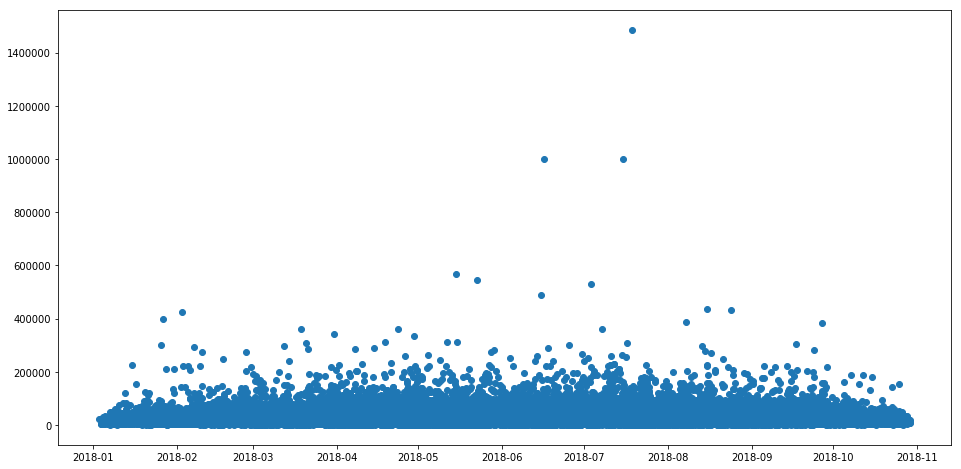

In [59]:
from matplotlib.dates import DateFormatter

fig, ax = plt.subplots(figsize=(16,8))

ax.plot_date(data_car_preprocessed.Online, data_car_preprocessed.Price)

ax.xaxis.set_major_formatter( DateFormatter('%Y-%m') )

plt.show()

In [61]:
# number of used car have high price, it's mean ulterieur 200000 euro
len(data_car_preprocessed[data_car_preprocessed.Price > 200000])

116

In [62]:
bins_price = np.linspace(min(data_car_preprocessed.Price), \
                         200000, \
                         4)
print(bins_price)
bins_price = list(bins_price)
# add a super high price
bins_price.append(max(data_car_preprocessed.Price))

bins_price

[1.00000000e+00 6.66673333e+04 1.33333667e+05 2.00000000e+05]


[1.0, 66667.33333333333, 133333.66666666666, 200000.0, 1486500.0]

In [63]:
group_names = ["Low", "Medium", "High", "Super High"]

data_car_preprocessed["price_binned"] = pd.cut(data_car_preprocessed.Price, \
                                                            bins_price, \
                                                            labels=group_names, \
                                                            include_lowest=True)



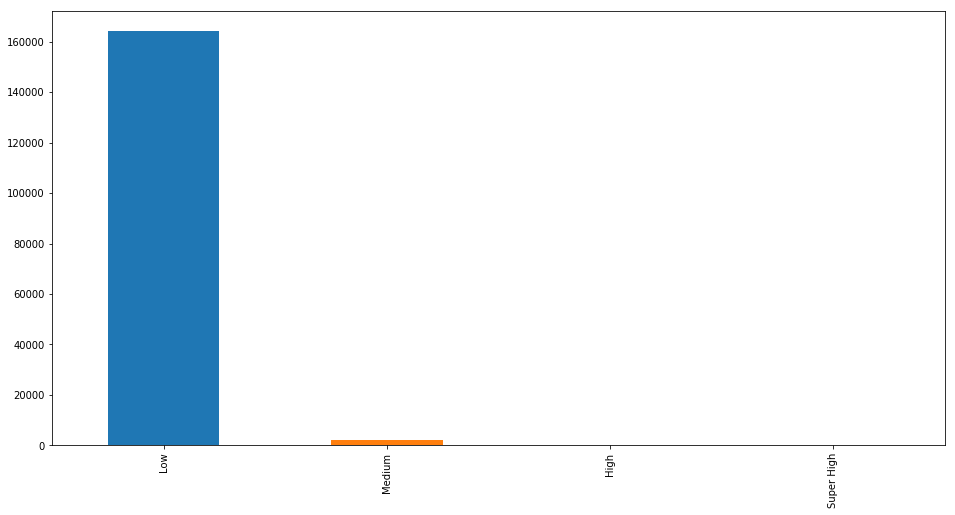

In [64]:
data_car_preprocessed.price_binned.value_counts().plot(kind='bar', figsize=(16,8))

<Figure size 1152x576 with 0 Axes>

/Users/nguyenkhacbaoanh/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


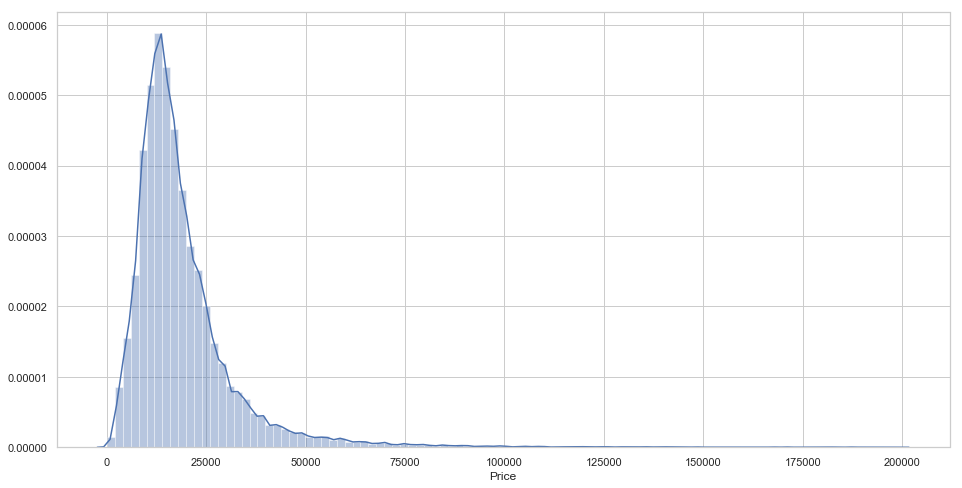

In [69]:
#plt.hist(data_car_preprocessed_non_duplicate.price_binned)
plt.figure(figsize=(16, 8))
#sns.distplot(data_car_preprocessed_non_duplicate.Price, bins=50)
sns.distplot(data_car_preprocessed[data_car_preprocessed.Price < 200000.0].Price, bins=100)

In [70]:
# expensive used car
data_car_preprocessed["log_price"] = np.log(data_car_preprocessed.Price)

<Figure size 1152x576 with 0 Axes>

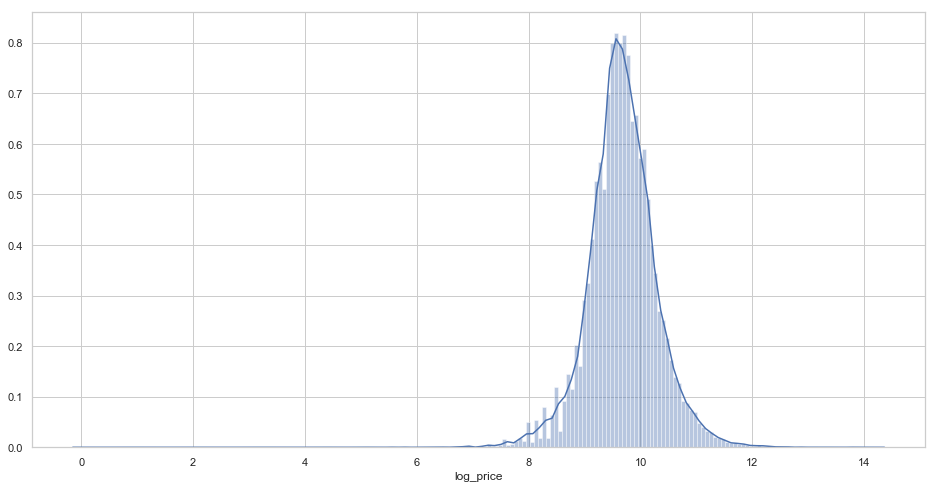

In [73]:
plt.figure(figsize=(16, 8))
sns.distplot(data_car_preprocessed.log_price, bins=200, norm_hist=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a21603358>,
      dtype=object)

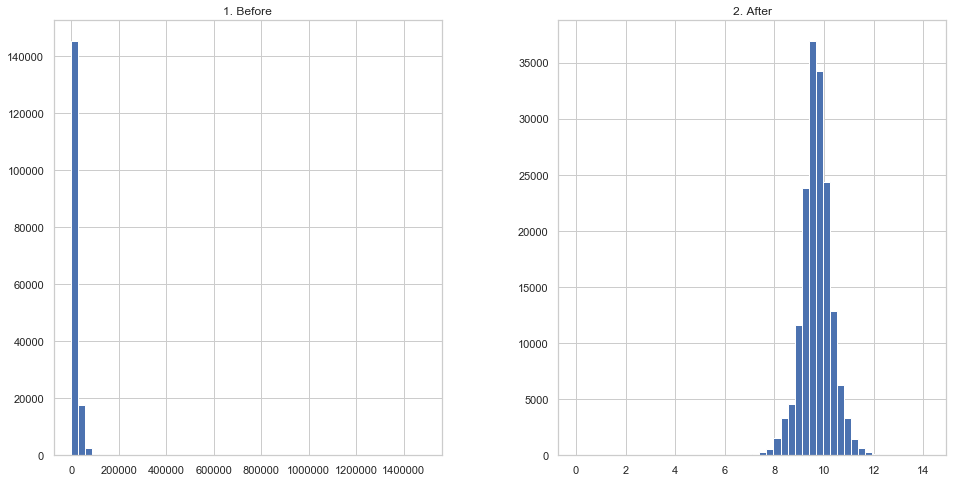

In [78]:
plt.rcParams['figure.figsize'] = (16, 8)
prices = pd.DataFrame({"1. Before":data_car_preprocessed["Price"], "2. After":data_car_preprocessed["log_price"]})
prices.hist(bins=50)

## <font color='Green'>Visualization price used car with</font>

### 1. <font color='blue'>Make</font>

In [40]:
data_car_preprocessed_non_duplicate.Make.nunique()

92

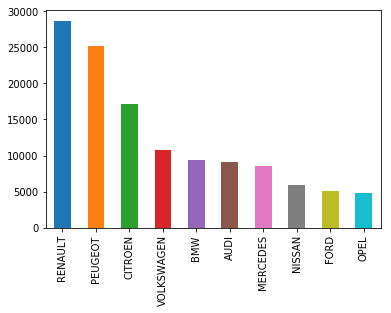

In [165]:
data_car_preprocessed_non_duplicate["Make"].value_counts()[:10].plot(kind='bar')

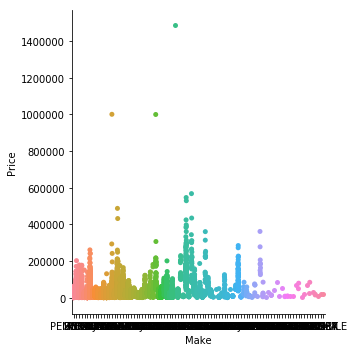

In [39]:
sns.catplot(x="Make", y="Price", data=data_car_preprocessed_non_duplicate);

In [44]:
data_car_preprocessed_non_duplicate.groupby(by="Make")["Price"].agg(lambda x: sum(x)/len(x)).sort_values().tail()

Make
ROLLS ROYCE    1.442489e+05
FERRARI        1.619987e+05
MCLAREN        1.973113e+05
LAMBORGHINI    1.980358e+05
BUGATTI        1.486500e+06
Name: Price, dtype: float64

In [48]:
data_car_preprocessed[data_car_preprocessed_non_duplicate.Make == "BMW-ALPINA"]

,Price,Make,Model,Model_year,Mileage,Fuel,Gearbox,Online,version,spuissance_fiscale,portes,options,couleur
3068,48135.0,BMW-ALPINA,B3 S,2012,29371.0,Essence,automatique,2018-04-13 00:41:00,coupe bi-turbo 400 switch-tronic,29,2.0,GPS 16/9;radar de recul;rétroviseurs électriqu...,gris


Text(0.5, 0, 'Brand')

Text(0, 0.5, 'Increase In price')

Text(0.5, 1.0, 'Brand Vs Price')

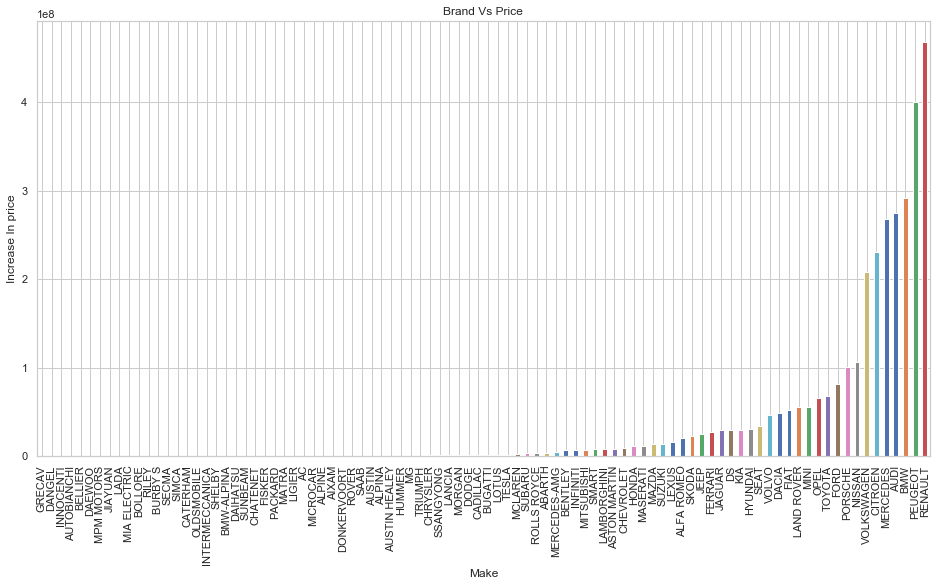

In [81]:
f, ax = plt.subplots(1,1, figsize=(16,8))
ax.set_xlabel('Make')
ax.set_ylabel('Increase In price')
ax.set_title("Make Vs Price")
data_car_preprocessed.groupby('Make').Price.sum().sort_values().plot(kind='bar')

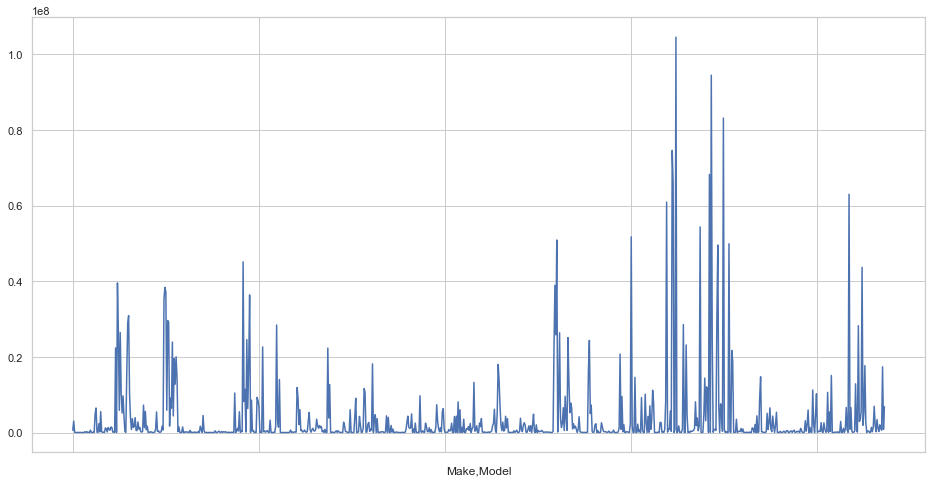

In [85]:
data_car_preprocessed.groupby(['Make', 'Model']).Price.sum().plot()

<Figure size 1152x576 with 0 Axes>

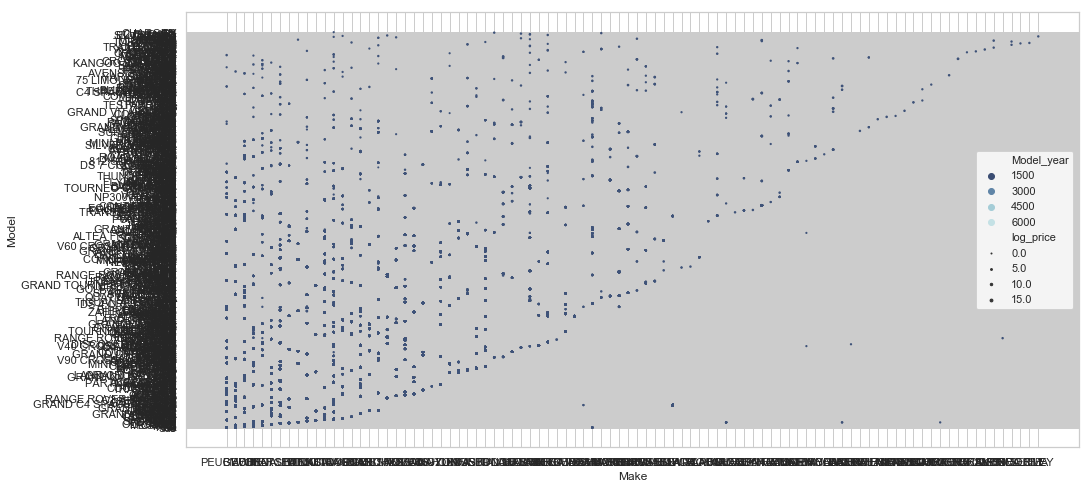

In [82]:
plt.figure(figsize=(16,8))
make_model_grouped = data_car_preprocessed.groupby(['Make', 'Model']).Price.sum()
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="Make", y="Model",
                hue="Model_year", size="log_price",
                palette="ch:r=-.2,d=.3_r",
                sizes=(1, 8), linewidth=0,
                data=data_car_preprocessed)

In [140]:
data_car_preprocessed["Make"].values

array(['PEUGEOT', 'BMW', 'AUDI', ..., 'FORD', 'SKODA', 'RENAULT'],
      dtype=object)

In [141]:
import scipy as sp
# analyst anova make vs price (Analyst of Variance)
data_annova = data_car_preprocessed_non_duplicate[["Make", "log_price"]]
grouped_annova = data_annova.groupby(by="Make")
annova_results_l = sp.stats.f_oneway(grouped_annova.get_group("PEUGEOT")["log_price"], \
                                  grouped_annova.get_group("RENAULT")["log_price"])
print(annova_results_l)

F_onewayResult(statistic=23.98395028063666, pvalue=9.742306476251108e-07)


### Question:
1. Comment on gere les voiture peu apparait dans la data?

<Figure size 1152x576 with 0 Axes>

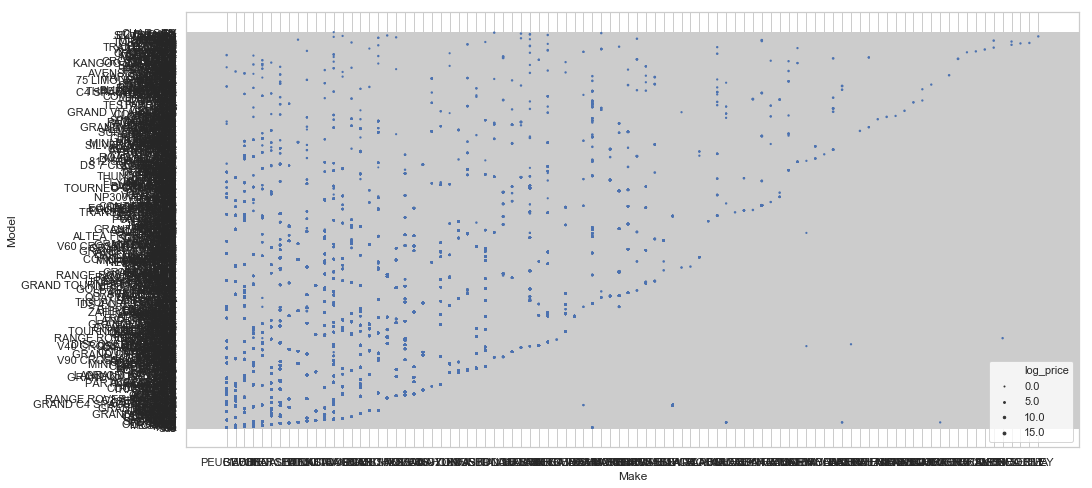

In [83]:
# Make + Model

plt.figure(figsize=(16,8))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="Make", y="Model",
                size="log_price",
                palette="ch:r=-.2,d=.3_r",
                sizes=(1, 8), linewidth=0,
                data=data_car_preprocessed)

### Model year

<Figure size 1152x576 with 0 Axes>

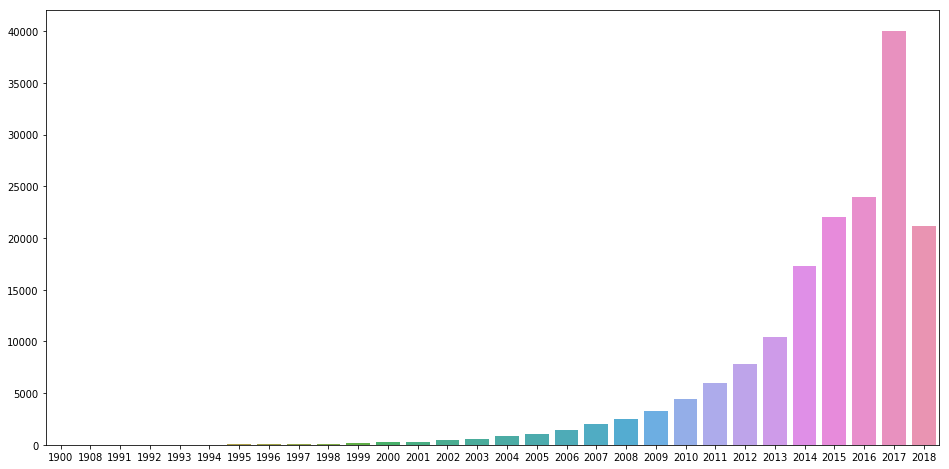

In [49]:
car_model = data_car.Model_year.value_counts(ascending=True, sort=False).tail(30)
plt.figure(figsize=(16,8))
sns.barplot(car_model.index, car_model.values)

In [27]:
data_car[data_car.Model_year == 1900]

,Price,Make,Model,Model_year,Mileage,Fuel,Gearbox,Online,Description
9401,41378.0,ABARTH,124,1900,1.0 km,Essence,mécanique,02/09/2018 à 0h56,"modele: 124 (2E GENERATION) SPIDER, version: S..."
9845,15020.0,FIAT,TIPO,1900,10.0 km,Diesel,mécanique,18/07/2018 à 9h37,"modele: , version: 5P EASY 5P 1.4 95, puissanc..."
48208,13068.0,FIAT,500,1900,10.0 km,Diesel,mécanique,11/07/2018 à 13h35,"modele: , version: LOUNGE 1.2 69, puissance_fi..."
75235,22508.0,FIAT,500 X,1900,10.0 km,Diesel,mécanique,23/06/2018 à 8h41,"modele: 500 X, version: URBAN LOOK LOUNGE 1.6 ..."
81348,30470.0,KIA,NIRO,1900,3039.0 km,Hybride essence électrique,automatique,19/05/2018 à 13h39,"modele: NIRO, version: 1.6 GDI 105 ISG + ELECT..."
84846,15200.0,FIAT,500,1900,10.0 km,Diesel,mécanique,28/03/2018 à 13h53,"modele: 500 C, version: II (2) C 1.2 8V 69 LOU..."
86000,20882.0,KIA,STONIC,1900,10.0 km,Diesel,mécanique,28/06/2018 à 10h34,"modele: STONIC, version: PREMIUM 1.6 CRDI 110 ..."
146096,14287.0,FIAT,TIPO,1900,2958.0 km,Diesel,mécanique,07/04/2018 à 21h29,"modele: , version: 5P EASY 5P 1.4 95, puissanc..."
157077,14635.0,FIAT,500,1900,10.0 km,Diesel,mécanique,01/08/2018 à 17h54,"modele: 500 C, version: LOUNGE 1.2 69, puissan..."
165353,9840.0,FIAT,PUNTO,1900,10.0 km,Diesel,mécanique,01/06/2018 à 16h23,"modele: , version: POP 1.2 69 5P 126G/KM, pu..."


In [29]:
data_car[data_car.Mileage == "1.0 km"].Model_year.value_counts()

2018    1254
2017     438
2016      26
2015       1
1951       1
1942       1
1900       1
Name: Model_year, dtype: int64

In [28]:
data_car[(data_car.Mileage == "1.0 km") & (data_car.Model_year == 1900)]

,Price,Make,Model,Model_year,Mileage,Fuel,Gearbox,Online,Description
9401,41378.0,ABARTH,124,1900,1.0 km,Essence,mécanique,02/09/2018 à 0h56,"modele: 124 (2E GENERATION) SPIDER, version: S..."


### 2. <font color='blue'> Make - Model - Model year</font>

In [123]:
grp_car = data_car_preprocessed.groupby(by=["Make", "Model", "Model_year"], as_index=False)["log_price"].agg(lambda x: sum(x)/len(x))
grp_car

,Make,Model,Model_year,log_price
0,ABARTH,124,1900,10.630505
1,ABARTH,124,2017,10.430477
2,ABARTH,124,2018,10.481080
3,ABARTH,500,2008,9.203316
4,ABARTH,500,2009,9.276675
5,ABARTH,500,2010,9.220291
6,ABARTH,500,2011,9.620025
7,ABARTH,500,2012,9.432564
8,ABARTH,500,2013,9.545079
9,ABARTH,500,2014,9.657366


make = data_car_preprocessed_non_duplicate["Make"].values
model_year = data_car_preprocessed_non_duplicate["Model_year"].values
model = data_car_preprocessed_non_duplicate["Model"].values
pd.crosstab(make, [model, model_year])

In [137]:
grp_pivot = pd.crosstab(grp_car["Make"], [grp_car["Model"], grp_car["Model_year"]], grp_car["log_price"], aggfunc=np.mean)
grp_pivot

Model              1000                1007                                \
Model_year         1980      1997      2005      2006      2007      2008   
Make                                                                        
ABARTH              NaN       NaN       NaN       NaN       NaN       NaN   
AC                  NaN       NaN       NaN       NaN       NaN       NaN   
AIXAM               NaN       NaN       NaN       NaN       NaN       NaN   
ALFA ROMEO          NaN       NaN       NaN       NaN       NaN       NaN   
ALPINA              NaN       NaN       NaN       NaN       NaN       NaN   
ALPINE              NaN       NaN       NaN       NaN       NaN       NaN   
ASTON MARTIN        NaN       NaN       NaN       NaN       NaN       NaN   
AUDI                NaN       NaN       NaN       NaN       NaN       NaN   
AUSTIN         9.099856  9.358674       NaN       NaN       NaN       NaN   
AUSTIN HEALEY       NaN       NaN       NaN       NaN       NaN       NaN   
AUTOBIANCHI         NaN       NaN       NaN       NaN       NaN       NaN   
BELLIER             NaN       NaN       NaN       NaN       NaN       NaN   
BENTLEY             NaN       NaN       NaN       NaN       NaN       NaN   
BMW                 NaN       NaN       NaN       NaN       NaN       NaN   
BMW-ALPINA          NaN       NaN       NaN       NaN       NaN       NaN   
BOLLORE             NaN       NaN       NaN       NaN       NaN       NaN   
BUGATTI             NaN       NaN       NaN       NaN       NaN       NaN   
BURBY S             NaN       NaN       NaN       NaN       NaN       NaN   
CADILLAC            NaN       NaN       NaN       NaN       NaN       NaN   
CATERHAM            NaN       NaN       NaN       NaN       NaN       NaN   
CHATENET            NaN       NaN       NaN       NaN       NaN       NaN   
CHEVROLET           NaN       NaN       NaN       NaN       NaN       NaN   
CHRYSLER            NaN       NaN       NaN       NaN       NaN       NaN   
CITROEN             NaN       NaN       NaN       NaN       NaN       NaN   
DACIA               NaN       NaN       NaN       NaN       NaN       NaN   
DAEWOO              NaN       NaN       NaN       NaN       NaN       NaN   
DAIHATSU            NaN       NaN       NaN       NaN       NaN       NaN   
DANGEL              NaN       NaN       NaN       NaN       NaN       NaN   
DODGE               NaN       NaN       NaN       NaN       NaN       NaN   
DONKERVOORT         NaN       NaN       NaN       NaN       NaN       NaN   
...                 ...       ...       ...       ...       ...       ...   
MINI                NaN       NaN       NaN       NaN       NaN       NaN   
MITSUBISHI          NaN       NaN       NaN       NaN       NaN       NaN   
MORGAN              NaN       NaN       NaN       NaN       NaN       NaN   
MPM MOTORS          NaN       NaN       NaN       NaN       NaN       NaN   
NISSAN              NaN       NaN       NaN       NaN       NaN       NaN   
OLDSMOBILE          NaN       NaN       NaN       NaN       NaN       NaN   
OPEL                NaN       NaN       NaN       NaN       NaN       NaN   
PACKARD             NaN       NaN       NaN       NaN       NaN       NaN   
PEUGEOT             NaN       NaN  8.302912  8.252465  8.315371  8.374349   
PORSCHE             NaN       NaN       NaN       NaN       NaN       NaN   
RENAULT             NaN       NaN       NaN       NaN       NaN       NaN   
RILEY               NaN       NaN       NaN       NaN       NaN       NaN   
ROLLS ROYCE         NaN       NaN       NaN       NaN       NaN       NaN   
ROVER               NaN       NaN       NaN       NaN       NaN       NaN   
SAAB                NaN       NaN       NaN       NaN       NaN       NaN   
SEAT                NaN       NaN       NaN       NaN       NaN       NaN   
SECMA               NaN       NaN       NaN       NaN       NaN       NaN   
SHELBY              NaN       NaN       NaN       NaN       NaN       NaN

In [ ]:
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
plt.figure(figsize=(16,8))
sns.scatterplot(x="distance", y="Price",
                     hue="year", size="mass",
                     palette=cmap, sizes=(10, 200),
                     data=data_car_preprocessed)

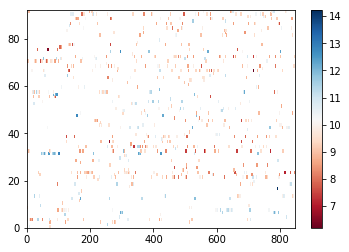

In [136]:
plt.pcolor(grp_pivot, cmap='RdBu')
plt.colorbar()
plt.show()

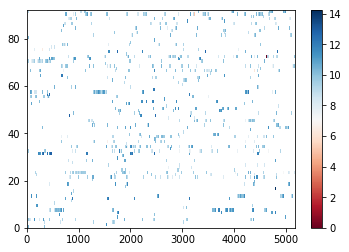

In [138]:
plt.pcolor(grp_pivot, cmap='RdBu')
plt.colorbar()
plt.show()

### 3. <font color='blue'> Mileage </font>

/Users/nguyenkhacbaoanh/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0, 1489531.2928301105)

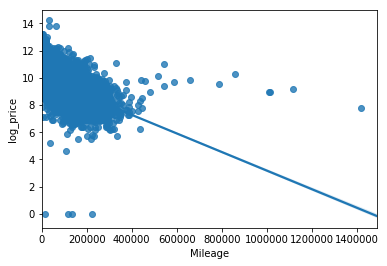

In [148]:
sns.regplot(x ='Mileage', y ='log_price', data = data_car_preprocessed_non_duplicate) 
plt.xlim(0,)

In [152]:
data_car_preprocessed_non_duplicate[data_car_preprocessed_non_duplicate.Mileage > 400000].Make.unique()

array(['CITROEN', 'RENAULT', 'NISSAN', 'AUDI', 'VOLVO', 'MERCEDES',
       'PEUGEOT', 'BMW', 'VOLKSWAGEN'], dtype=object)

/Users/nguyenkhacbaoanh/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


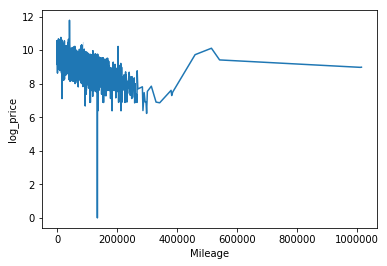

In [155]:
sns.lineplot(x ='Mileage', y ='log_price', data = data_car_preprocessed_non_duplicate[data_car_preprocessed_non_duplicate.Make == 'CITROEN'])

### 4. <font color='blue'> Fuel </font>

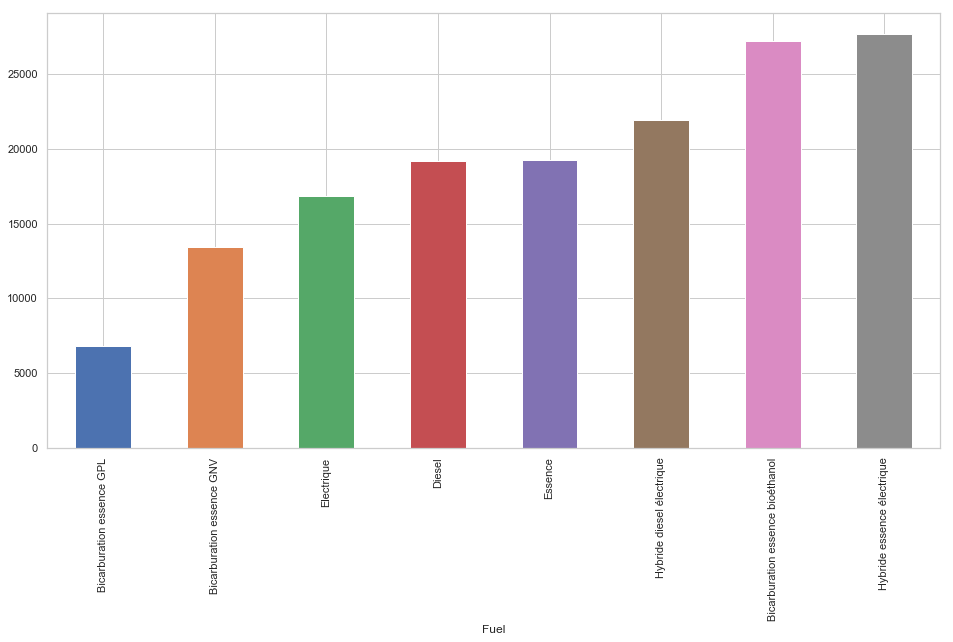

In [103]:
data_car_preprocessed.groupby(by="Fuel")["Price"].agg(np.mean).sort_values().plot(kind='bar', figsize=(16,8))

### 5. <font color='blue'> Gearbox </font>

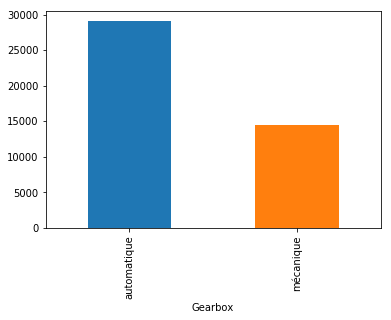

In [158]:
data_car_preprocessed_non_duplicate.groupby(by="Gearbox")["Price"].agg(np.mean).plot(kind='bar')

### Visualize Prive vs Mileage (Fuel + Gearbox)

<Figure size 1152x576 with 0 Axes>

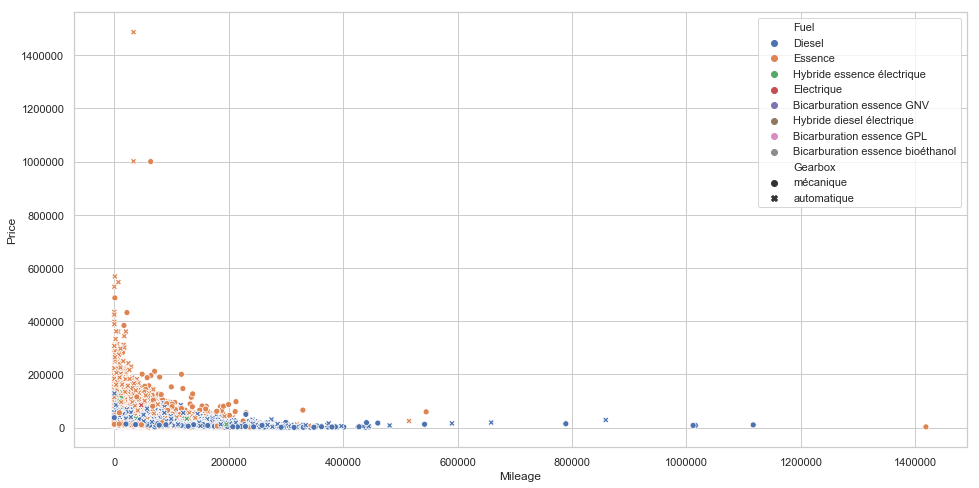

In [96]:
plt.figure(figsize=(16,8))
sns.scatterplot(x="Mileage", y="Price",
                     hue="Fuel", style="Gearbox",
                     data=data_car_preprocessed)

## Test Hypothèse:
1. Correlation entre Price et Mileage
2. Price vs 

In [170]:
from scipy.stats import pearsonr, levene, ttest_ind
corr_pearsonr, p_value = pearsonr(data_car_preprocessed_non_duplicate.Price, \
                                  data_car_preprocessed_non_duplicate.Mileage)
print("pearson correlation: {:.2f} with P value: {:.2f}".format(corr_pearsonr, p_value))
stats_results, p_value = levene(data_car_preprocessed_non_duplicate.Price, \
                                  data_car_preprocessed_non_duplicate.Mileage)
print("Checking homogeneity of variance: statistic: {:.2f} with P value: {:.2f}".format(stats_results, p_value))

pearson correlation: -0.30 with P value: 0.00
Checking homogeneity of variance: statistic: 85597.67 with P value: 0.00


Avec Pearson test:
    - price and lieage est faible corrélé (-0.3) avec p value est 0. Avec fiabitité 95%, Price et Lieage n'est pas corrélé

Avec Levene test: (valeur du statistic est plus grand et p value est plus petit, on refuse H0, cad, les deux variable n'est pas corrélé
    - Test variance a le statistic est très grand et P value est 0 => Passer une autre test

In [173]:
stats_results, p_value = ttest_ind(data_car_preprocessed_non_duplicate.Price, \
                                  data_car_preprocessed_non_duplicate.Mileage)
print("the result of the Welch’s test: statistic: {:.2f} with P value: {:.2f}".format(stats_results, p_value))

the result of the Welch’s test: statistic: -404.07 with P value: 0.00


## Test normality

Comme on a analysé sur le prix, le histogram du prix ne semble pas distribution normal mais, si on fait log sur le prix, il resemble maintenant distribution normale. Mais il faut vérifier

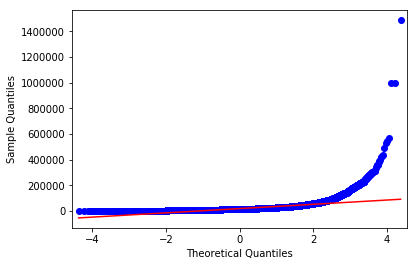

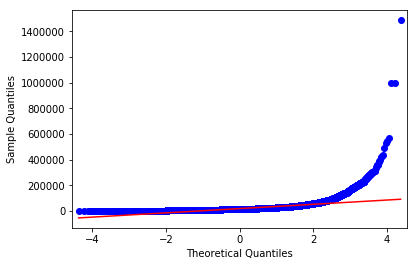

In [177]:
qqplot(data_car_preprocessed_non_duplicate.Price, line='s')

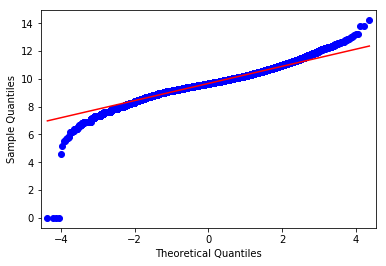

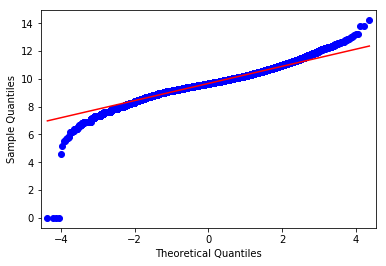

In [183]:
from statsmodels.graphics.gofplots import qqplot
qqplot(data_car_preprocessed_non_duplicate.log_price, line='s')
#plt.show()

Text(0.5, 0, 'Price')

Text(0, 0.5, 'Lieage')

Text(0.5, 1.0, 'Price vs Mileage')

Text(0.5, 0, 'Price')

Text(0, 0.5, 'Lieage')

Text(0.5, 1.0, 'Log Price vs Mileage')

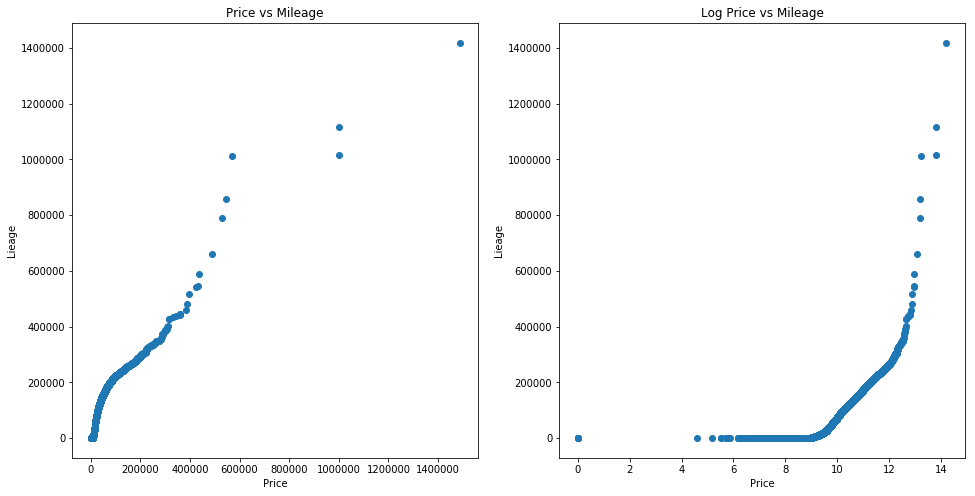

In [192]:
fig, ax = plt.subplots(1, 2, figsize=(16,8))
ax = ax.flatten()
ax[0].scatter(np.sort(data_car_preprocessed_non_duplicate.Price), np.sort(data_car_preprocessed_non_duplicate.Mileage))
ax[0].set_xlabel('Price')
ax[0].set_ylabel('Lieage')
ax[0].set_title("Price vs Mileage")
ax[1].scatter(np.sort(data_car_preprocessed_non_duplicate.log_price), np.sort(data_car_preprocessed_non_duplicate.Mileage))
ax[1].set_xlabel('Price')
ax[1].set_ylabel('Lieage')
ax[1].set_title("Log Price vs Mileage")
plt.show()
plt.close()

In [194]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

label_encoder.fit_transform(data_car_preprocessed_non_duplicate.Make)

array([70, 13,  7, ..., 34, 81, 72])

In [196]:
categorical_v = ["Make", "Model", "Model_year", "Fuel", "Gearbox", "version", "couleur"]
data_car_preprocessed_non_duplicate[categorical_v] = data_car_preprocessed_non_duplicate[categorical_v].apply(LabelEncoder().fit_transform)

In [197]:
data_car_preprocessed_non_duplicate.head(10)

,Price,Make,Model,Model_year,Mileage,Fuel,Gearbox,Online,version,spuissance_fiscale,portes,options,couleur,price_binned,log_price
0,11220.0,70,46,66,94341.0,3,1,2018-07-06 03:47:00,10231,4,5.0,banquette arrière 3 places;volant cuir;cache b...,881,Low,9.325453
1,57526.0,13,814,67,39051.0,3,0,2018-04-03 16:41:00,4407,16,5.0,triangle de presignalisation et trousse de pre...,2194,Low,10.959992
2,80379.0,7,635,66,75381.0,5,0,2018-07-30 01:55:00,25379,47,5.0,banquette arrière 3 places;écran tactile;témoi...,4957,Medium,11.294508
3,2830.0,34,462,59,92282.0,5,1,2018-07-09 14:12:00,7044,5,3.0,direction assistée;jantes alu;rétroviseurs éle...,4089,Low,7.948032
4,12925.0,32,739,70,10.0,5,1,2018-05-19 03:52:00,21956,5,5.0,Volant alu & cuir;Bluetooth inclut musique en ...,1258,Low,9.466919
5,27956.0,13,811,64,95623.0,3,0,2018-03-14 04:24:00,4866,20,5.0,vitrage calorifuge;triangle de presignalisatio...,6130,Low,10.238387
6,16888.0,7,114,65,49018.0,3,1,2018-04-16 21:35:00,18545,7,5.0,"""anti démarrage;radar de recul;prises audio au...",3004,Low,9.734359
7,18188.0,72,507,69,9795.0,3,0,2018-04-29 12:44:00,28053,5,5.0,régulateur limiteur de vitesse;carte main libr...,2650,Low,9.808517
8,10594.0,34,186,64,126670.0,3,1,2018-06-22 05:11:00,20044,6,5.0,,2021,Low,9.268043
9,69131.0,57,240,67,39439.0,5,0,2018-03-08 17:35:00,5807,40,4.0,régulateur limiteur de vitesse;affichage tête ...,4607,Medium,11.143759
